In [1]:
from dataclasses import dataclass
import torchvision
import torchvision.transforms as TF
import torchvision.datasets as datasets
from torch.utils.data import Dataset, DataLoader
import os
import torch
from tqdm import tqdm

def get(element: torch.Tensor, t: torch.Tensor):
    """
    Get value at index position "t" in "element" and
        reshape it to have the same dimension as a batch of images.
    """
    ele = element.gather(-1, t)
    return ele.reshape(-1, 1, 1, 1)
    
class SimpleDiffusion:
    def __init__(
        self,
        num_diffusion_timesteps,
        device="cpu",
    ):
        self.num_diffusion_timesteps = num_diffusion_timesteps
        self.device = device
        self.initialize()
 
    def initialize(self):
        # BETAs & ALPHAs required at different places in the Algorithm.
        self.beta  = self.get_betas()
        self.alpha = 1 - self.beta
         
        self_sqrt_beta                       = torch.sqrt(self.beta).to(self.device)
        self.alpha_cumulative                = torch.cumprod(self.alpha, dim=0).to(self.device)
        self.sqrt_alpha_cumulative           = torch.sqrt(self.alpha_cumulative).to(self.device)
        self.one_by_sqrt_alpha               = 1. / torch.sqrt(self.alpha).to(self.device)
        self.sqrt_one_minus_alpha_cumulative = torch.sqrt(1 - self.alpha_cumulative).to(self.device)
          
    def get_betas(self):
        """linear schedule, proposed in original ddpm paper"""
        scale = 100 / self.num_diffusion_timesteps
        beta_start = scale * 1e-4
        beta_end = scale * 0.02
        return torch.linspace(
            beta_start,
            beta_end,
            self.num_diffusion_timesteps,
            dtype=torch.float32,
            device=self.device,
        )
        
def forward_diffusion(sd: SimpleDiffusion, x0: torch.Tensor, timesteps: torch.Tensor):
    eps = torch.randn_like(x0)  # Noise
    mean    = get(sd.sqrt_alpha_cumulative.to(sd.device), t=timesteps) * x0  # Image scaled
    std_dev = get(sd.sqrt_one_minus_alpha_cumulative, t=timesteps) # Noise scaled
    sample  = mean + std_dev * eps # scaled inputs * scaled noise

    return sample, eps  # return ... , gt noise --> model predicts this

In [2]:
from ipsl_dcpp.model.pangu import PanguWeather
from hydra import compose, initialize
from omegaconf import OmegaConf
import lightning as pl

import hydra
import os
os.environ['SLURM_NTASKS_PER_NODE'] = '1'
#torch.set_default_dtype(torch.float32)
# os.environ["CUDA_VISIBLE_DEVICES"]=""
#torch.set_default_tensor_type(torch.FloatTensor)

with initialize(version_base=None, config_path="conf"):
    cfg = compose(config_name="config")
pl.seed_everything(cfg.experiment.seed)
train = hydra.utils.instantiate(
    cfg.experiment.train_dataset,
    generate_statistics=False,
    surface_variables=cfg.experiment.surface_variables,
    depth_variables=cfg.experiment.depth_variables,
    plev_variables=cfg.experiment.plev_variables,
    normalization='climatology',
    delta=True,
    work_path=cfg.environment.work_path,
    scratch_path=cfg.environment.scratch_path,
)

train_dataloader = torch.utils.data.DataLoader(
    train,
    batch_size=1,
    shuffle=True,
    num_workers=1
)
sd = SimpleDiffusion(num_diffusion_timesteps=5, device="cpu")

/gpfsdswork/projects/rech/mlr/udy16au/miniconda3/envs/env_gpu5/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
[rank: 0] Seed set to 0


In [6]:
cfg.experiment.surface_variables.index('cVeg')

6

In [33]:
#from torchvision.utils import make_grid

# noisy_images = []
# specific_timesteps = [0, 10, 50, 100, 150, 200, 250, 300, 400, 600, 800, 999]
 
# for timestep in specific_timesteps:
#     timestep = torch.as_tensor(timestep, dtype=torch.long)
 
#     xts, _ = sd.forward_diffusion(x0s, timestep)
#     xts    = inverse_transform(xts) / 255.0
#     xts    = make_grid(xts, nrow=1, padding=1)
     
#     noisy_images.append(xts)
# import matplotlib.pyplot as plt
# _, ax = plt.subplots(1, len(noisy_images), figsize=(10, 5), facecolor='white')

# for i, (timestep, noisy_sample) in enumerate(zip(specific_timesteps, noisy_images)):
#     ax[i].imshow(noisy_sample.squeeze(0).permute(1, 2, 0)[:,:,90])
#     ax[i].set_title(f"t={timestep}", fontsize=8)
#     ax[i].axis("off")
#     ax[i].grid(False)

# plt.suptitle("Forward Diffusion Process", y=0.9)
# plt.axis("off")
# plt.show()

In [4]:
from torchmetrics import MeanMetric

def train_one_epoch(model, sd, loader, optimizer, scaler, loss_fn, epoch=800):
    
    loss_record = MeanMetric()
    model.train()

    with tqdm(total=len(loader), dynamic_ncols=True) as tq:
        tq.set_description(f"Train :: Epoch: {epoch}/{1}")
         
        for x in loader:
            x0s = x['state_surface'].squeeze()[6]
            tq.update(1)
            
            ts = torch.randint(low=1, high=5, size=(1,), device='cpu')
            xts, gt_noise = forward_diffusion(sd, x0s, ts)
            pred_noise = model(xts, ts).squeeze()
            loss = loss_fn(gt_noise, pred_noise)

            optimizer.zero_grad(set_to_none=True)
            scaler.scale(loss).backward()

            # scaler.unscale_(optimizer)
            # torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

            scaler.step(optimizer)
            scaler.update()

            loss_value = loss.detach().item()
            loss_record.update(loss_value)

            tq.set_postfix_str(s=f"Loss: {loss_value:.4f}")

        mean_loss = loss_record.compute().item()
    
        tq.set_postfix_str(s=f"Epoch Loss: {mean_loss:.4f}")
    
    return mean_loss 

In [5]:
# Algorithm 2: Sampling
    
@torch.inference_mode()
def reverse_diffusion(model, sd, timesteps=5,
                      num_images=1, nrow=8, device="cpu", **kwargs):
    
    x = torch.randn((1,1,143,144), device=device)
    beginning_noise = x
    model.eval()

    outs = []

    for time_step in tqdm(iterable=reversed(range(1, timesteps)), 
                          total=timesteps-1, dynamic_ncols=False, 
                          desc="Sampling :: ", position=0):

        ts = torch.ones(1, dtype=torch.long, device=device) * time_step
        z = torch.randn_like(x) if time_step > 1 else torch.zeros_like(x)
        predicted_noise = model(x, ts)

        beta_t                            = get(sd.beta, ts)
        one_by_sqrt_alpha_t               = get(sd.one_by_sqrt_alpha, ts)
        sqrt_one_minus_alpha_cumulative_t = get(sd.sqrt_one_minus_alpha_cumulative, ts) 

        x = (
            one_by_sqrt_alpha_t
            * (x - (beta_t / sqrt_one_minus_alpha_cumulative_t) * predicted_noise)
            + torch.sqrt(beta_t) * z
        )
    #     if kwargs.get("generate_video", False):
        grid = torchvision.utils.make_grid(x, nrow=nrow, pad_value=255.0).to("cpu")
        ndarr = torch.permute(grid, (1, 2, 0)).numpy()[:, :, ::-1]
        outs.append(ndarr)

    # if kwargs.get("generate_video", False): # Generate and save video of the entire reverse process. 
    #     frames2vid(outs, kwargs['save_path'])
    #     display(Image.fromarray(outs[-1][:, :, ::-1])) # Display the image at the final timestep of the reverse process.
    #     return None

    #else: # Display and save the image at the final timestep of the reverse process. 
       # x = inverse_transform(x).type(torch.uint8)
    print(x.shape)
    grid = torchvision.utils.make_grid(x, nrow=nrow, pad_value=255.0).to("cpu")
    pil_image = TF.functional.to_pil_image(grid)
    pil_image.save(f'img_{timesteps}.png', format='png')
    display(pil_image)
    return x,beginning_noise,outs

In [6]:
@dataclass
class ModelConfig:
    BASE_CH = 64  # 64, 128, 256, 512
    BASE_CH_MULT = (1, 2, 4, 8) # 32, 16, 8, 4 
    APPLY_ATTENTION = (False, False, True, False)
    DROPOUT_RATE = 0.1
    TIME_EMB_MULT = 2 # 128
import torch.nn as nn
from torch.cuda import amp
from model.unet import UNet2
model = UNet2(
    n_channels=1,n_out_channels=1,
)
model.to('cpu')

optimizer = torch.optim.AdamW(model.parameters(), lr=0.0001)

loss_fn = nn.MSELoss()

scaler = amp.GradScaler()

/Users/gclyne/miniforge3/envs/env_dcpp/lib/python3.12/site-packages/torch/cuda/amp/grad_scaler.py:126: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn(


In [7]:
torch.autograd.set_detect_anomaly(True)
for epoch in range(1, 15):
 #   torch.cuda.empty_cache()
  #  gc.collect()
    
    # Algorithm 1: Training
    train_one_epoch(model, sd, train_dataloader, optimizer, scaler, loss_fn, epoch=epoch)

    # if epoch % 5 == 0:
    #   #  save_path = os.path.join(log_dir, f"{epoch}{ext}")
        
    #     # Algorithm 2: Sampling
    #     reverse_diffusion(model, sd, timesteps=100, num_images=32, generate_video=generate_video,
    #         save_path=save_path, device='cpu',
    #     )

    #     checkpoint_dict = {
    #         "opt": optimizer.state_dict(),
    #         "scaler": scaler.state_dict(),
    #         "model": model.state_dict()
    #     }
    #     torch.save(checkpoint_dict, "ckpt.tar")

Train :: Epoch: 1/1:   0%|          | 0/119 [00:00<?, ?it/s]/Users/gclyne/miniforge3/envs/env_dcpp/lib/python3.12/site-packages/torch/utils/data/_utils/collate.py:183: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at /Users/runner/work/_temp/anaconda/conda-bld/pytorch_1708025535429/work/torch/csrc/utils/tensor_numpy.cpp:212.)
  return collate([torch.as_tensor(b) for b in batch], collate_fn_map=collate_fn_map)
Train :: Epoch: 2/1:   0%|          | 0/119 [00:00<?, ?it/s]/Users/gclyne/miniforge3/envs/env_dcpp/lib/python3.12/site-packages/torch/utils/data/_utils/collate.py:183: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable te

In [8]:

checkpoint_dict = {
    "opt": optimizer.state_dict(),
    "scaler": scaler.state_dict(),
    "model": model.state_dict()
}
torch.save(checkpoint_dict, "ckpt.tar")

Sampling :: 100%|██████████| 4/4 [00:00<00:00, 15.85it/s]

torch.Size([1, 1, 143, 144])


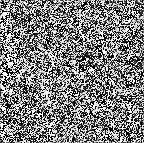

In [9]:
model.load_state_dict(torch.load("ckpt.tar", map_location='cpu')['model'])
x = reverse_diffusion(model=model,sd=sd,timesteps=5,num_images=1,nrow=8,device='cpu',generate_video=False,save_path='output.png')

In [15]:
x[-1]
pil_image = TF.functional.to_pil_image(x[-1][4])
pil_image

IndexError: list index out of range

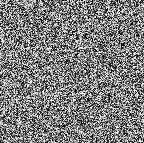